In [1]:
import numpy as np
import pandas
import seaborn
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, validation_curve

In [2]:
column_to_predict = 'median_house_value'
categories_columns = ['ocean_proximity']
numerics_columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

data_frame = pandas.read_csv(filepath_or_buffer='cal-housing.csv')
#data_frame = data_frame.sample(frac=1).reset_index(drop=True)

columns_categories = pandas.DataFrame()

for c in categories_columns:
    column = pandas.get_dummies(data=data_frame[c], prefix=c + '_')
    columns_categories = pandas.concat((columns_categories, column), axis=1)

#data_frame.drop(columns=categories_columns, inplace=True)
#data_frame = pandas.concat([data_frame, columns_categories], axis=1)

outliers = data_frame[data_frame[column_to_predict] == 500001].index
data_frame.drop(outliers, inplace=True)

y = data_frame[column_to_predict].values

#columns_to_remove = ['households', 'total_bedrooms', column_to_predict]
#columns_to_remove = ['ocean_proximity', 'population', 'total_rooms', column_to_predict]
#columns_to_remove = ['latitude', 'population', 'total_rooms', column_to_predict]
columns_to_remove = ['ocean_proximity', column_to_predict]

columns_to_use = list(data_frame.columns)

for u in columns_to_remove:
    columns_to_use.remove(u)
    if numerics_columns.count(u) > 0:
        numerics_columns.remove(u)

data_frame.drop(columns=columns_to_remove, inplace=True)

for c in data_frame.columns:
    if data_frame[c].hasnans:
        m = data_frame[c].mean()
        data_frame[c].fillna(value=m, inplace=True)

data_frame

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462
...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672


In [3]:
X = data_frame.values

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)

In [5]:
regressor = Ridge(alpha=0.001, fit_intercept=True, normalize=True)
regressor.fit(x_train, y_train)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

In [6]:
y_pred = regressor.predict(x_test)

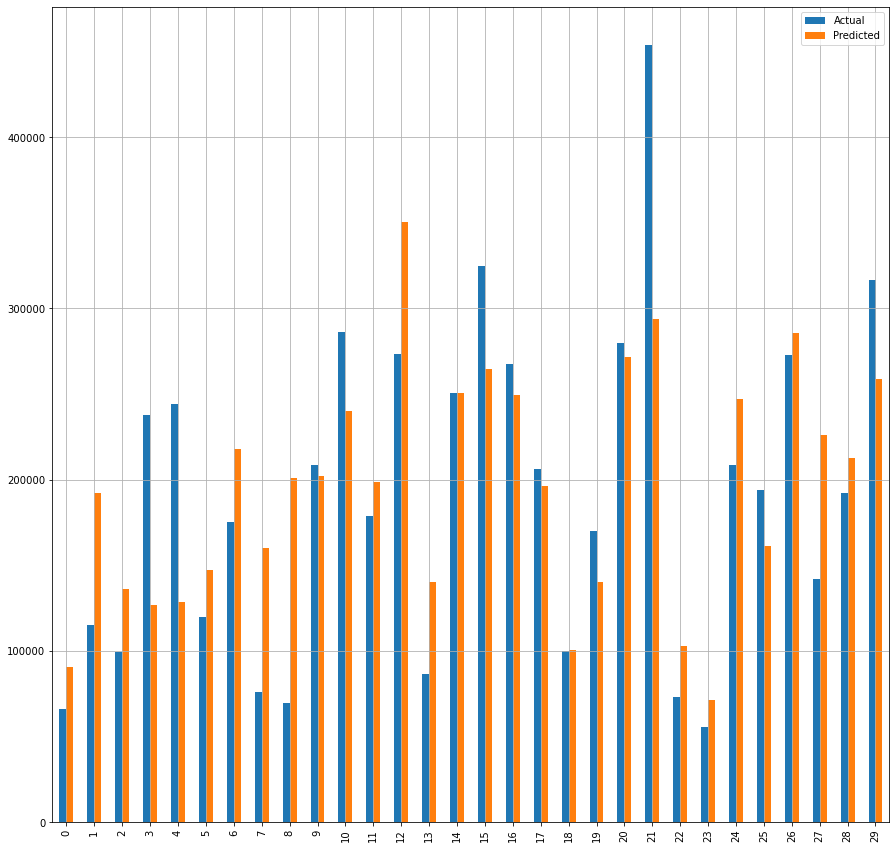

In [7]:
df = pandas.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(30)

df1.plot(kind='bar', figsize=(15, 15))
plt.grid()
plt.show()

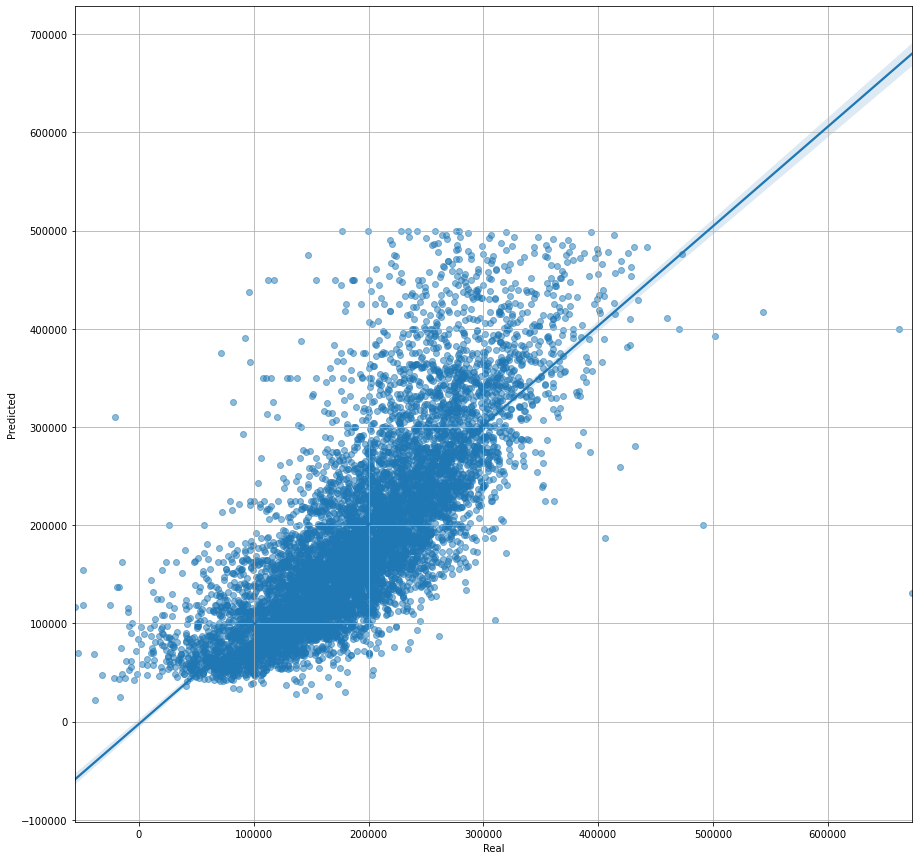

In [8]:
plt.figure(figsize=(15, 15))

seaborn.regplot(y_pred, y_test, scatter_kws={'alpha':0.5})

plt.xlabel('Real')
plt.ylabel('Predicted')

plt.grid()
plt.show()

In [9]:
print('R²:', metrics.r2_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R²: 0.6005757219151278
Mean Absolute Error: 45931.06194147338
Mean Squared Error: 3815187939.4608006
Root Mean Squared Error: 61767.20763852613


### Cross validation

In [10]:
RMS = 'neg_mean_squared_error'
alpha_vals = np.linspace(0, 1, 50)

train_score__c, val_score__c = validation_curve(regressor, X, y, 'alpha', alpha_vals, cv=5, scoring=RMS, n_jobs=-1)

In [11]:
train_score_mean__c = -np.mean(train_score__c, axis=1)
train_score_std__c = np.std(train_score__c, axis=1)
val_score_mean__c = -np.mean(val_score__c, axis=1)
val_score_std__c = np.std(val_score__c, axis=1)

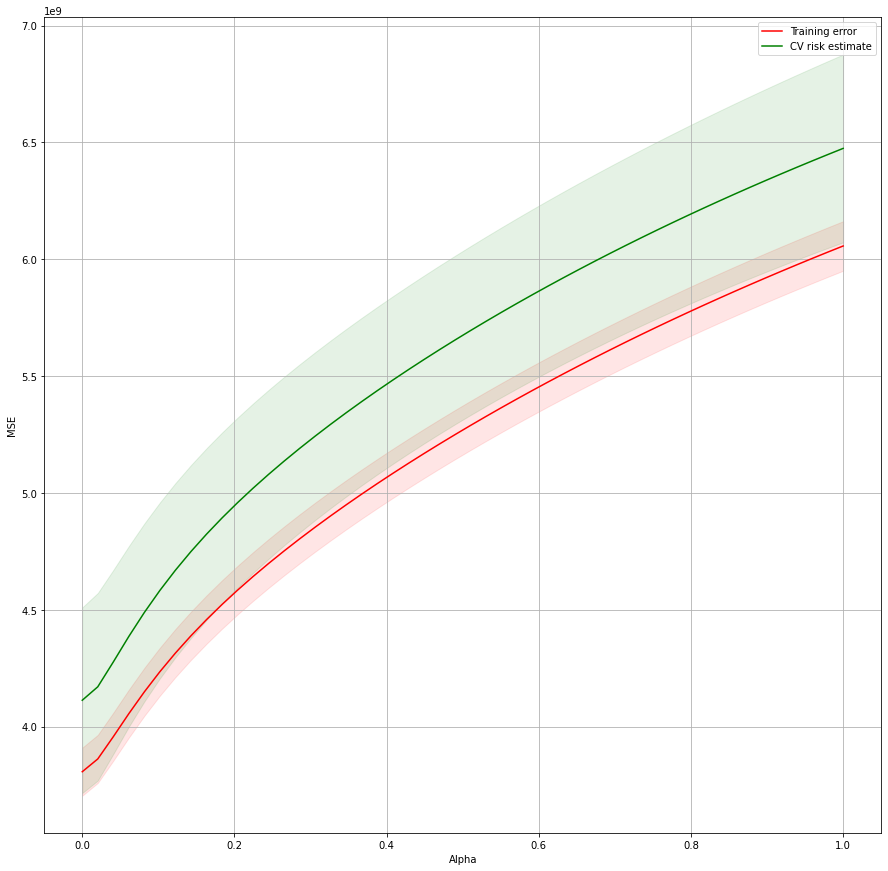

In [12]:
plt.figure(figsize=(15, 15))

plt.fill_between(alpha_vals, train_score_mean__c - train_score_std__c, train_score_mean__c + train_score_std__c, alpha=0.1, color="r")
plt.fill_between(alpha_vals, val_score_mean__c - val_score_std__c, val_score_mean__c + val_score_std__c, alpha=0.1, color="g")

plt.plot(alpha_vals, train_score_mean__c, color="r", label="Training error")
plt.plot(alpha_vals, val_score_mean__c, color="g", label="CV risk estimate")

plt.xlabel('Alpha')
plt.ylabel('MSE')

plt.grid()
plt.legend()
plt.show()